**_<mark>For more accuracy run every engine in a separate notebooks to ignore Disk Cache</mark>_**

In [1]:
!pip install  -q duckdb --upgrade --pre
!pip install  -q polars --upgrade --pre

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 3, Finished, Available)

In [2]:
## if running inside Fabric or Databricks etc, delete this cell as Spark is installed by default
#!pip install -q delta-spark
#import pyspark
#from delta import *
#builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
#    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
#    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
#spark = configure_spark_with_delta_pip(builder).getOrCreate()
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 4, Finished, Available)

In [3]:
from psutil import *
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
print(vCPU +' Memory:'+ str(mem))

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 5, Finished, Available)

4 vCPU Memory:31.0


In [4]:
total_files = 1
raw_landing='/lakehouse/default/Files/raw'

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 6, Finished, Available)

# Download Data

In [5]:
# @title
import re ,os
import requests
from urllib.request import urlopen
def download(url,Path):
    if not os.path.exists(Path):
      os.makedirs(Path, exist_ok=True)
    result = urlopen(url).read().decode('utf-8')
    pattern = re.compile(r'[\w.]*.zip')
    filelist1 = pattern.findall(result)
    filelist_unique = list(set(filelist1))[:total_files]
    print(str(len(filelist_unique)) + ' New File Loaded')
    if len(filelist_unique) != 0 :
      for x in filelist_unique:
           with requests.get(url+x, stream=True) as resp:
            if resp.ok:
              with open(f"{Path}/{x}", "wb") as f:
               for chunk in resp.iter_content(chunk_size=4096):
                f.write(chunk)
    return "done"

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 7, Finished, Available)

_**UNZIP**_

In [6]:
from shutil import unpack_archive
import os , glob
def unzip(Source, Destination):
    filelist=[os.path.basename(x) for x in glob.glob(Source+'*.zip')]
    for x in filelist:
          try:
            unpack_archive(str(Source+x), str(Destination), 'zip')
          except:
            pass
    return "done"

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 8, Finished, Available)

In [7]:
#download("https://nemweb.com.au/Reports/Current/Daily_Reports/",raw_landing+"/zip/")
#unzip(raw_landing+"/zip/",raw_landing+"/csv/")

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 9, Finished, Available)

# DuckDB

In [8]:
%%time
import duckdb
def duckdb_clean_csv(x):
	raw =duckdb.sql(F"""from read_csv({x},
	Skip=1,header =0,all_varchar=1,
	columns={{
	'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
	'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
	'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
	'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
	'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
	'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
	'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
	'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
	'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
	'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
	'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
	'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
	'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
	'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
	'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
	'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3                  """)
	columns = list(set(raw.columns) - {'SETTLEMENTDATE','DUID','I','filename','UNIT'})
	exprs = [
		duckdb.ColumnExpression(x).cast(duckdb.typing.DOUBLE).alias(x)
		for x in columns
	         ]
	rel2 = raw.select('SETTLEMENTDATE','DUID','I','filename','UNIT',*exprs)

	scada=duckdb.sql(""" select *exclude(SETTLEMENTDATE,I,XX,filename),cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
	isoyear (cast (SETTLEMENTDATE as timestamp)) as YEAR  from rel2  """)
	return scada.df()

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 10, Finished, Available)

CPU times: user 26.3 ms, sys: 10.7 ms, total: 37 ms
Wall time: 39.7 ms


# Polars

In [9]:
%%time
import polars as pl
def polars_clean_csv(x):
  schema ={'I': pl.String,'UNIT': pl.String,'XX': pl.String,'VERSION': pl.String,'SETTLEMENTDATE': pl.String,'RUNNO': pl.String,
    'DUID': pl.String,'INTERVENTION': pl.String,'DISPATCHMODE': pl.String,'AGCSTATUS': pl.String,'INITIALMW': pl.String,
    'TOTALCLEARED': pl.String,'RAMPDOWNRATE': pl.String,'RAMPUPRATE': pl.String,'LOWER5MIN': pl.String,
    'LOWER60SEC': pl.String,'LOWER6SEC': pl.String,'RAISE5MIN': pl.String,'RAISE60SEC': pl.String,
    'RAISE6SEC': pl.String,'MARGINAL5MINVALUE': pl.String,'MARGINAL60SECVALUE': pl.String,
    'MARGINAL6SECVALUE': pl.String,'MARGINALVALUE': pl.String,'VIOLATION5MINDEGREE': pl.String,
    'VIOLATION60SECDEGREE': pl.String,'VIOLATION6SECDEGREE': pl.String,'VIOLATIONDEGREE': pl.String,
    'LOWERREG': pl.String,'RAISEREG': pl.String,'AVAILABILITY': pl.String,'RAISE6SECFLAGS': pl.String,
    'RAISE60SECFLAGS': pl.String,'RAISE5MINFLAGS': pl.String,'RAISEREGFLAGS': pl.String,
    'LOWER6SECFLAGS': pl.String,'LOWER60SECFLAGS': pl.String,'LOWER5MINFLAGS': pl.String,
    'LOWERREGFLAGS': pl.String,'RAISEREGAVAILABILITY': pl.String,'RAISEREGENABLEMENTMAX': pl.String,
    'RAISEREGENABLEMENTMIN': pl.String,'LOWERREGAVAILABILITY': pl.String,'LOWERREGENABLEMENTMAX': pl.String,
    'LOWERREGENABLEMENTMIN': pl.String,'RAISE6SECACTUALAVAILABILITY': pl.String,
    'RAISE60SECACTUALAVAILABILITY': pl.String,'RAISE5MINACTUALAVAILABILITY': pl.String,
    'RAISEREGACTUALAVAILABILITY': pl.String,'LOWER6SECACTUALAVAILABILITY': pl.String,
    'LOWER60SECACTUALAVAILABILITY': pl.String,'LOWER5MINACTUALAVAILABILITY': pl.String,'LOWERREGACTUALAVAILABILITY': pl.String}
  raw = pl.scan_csv(x,
                    skip_rows=1,
                    schema=schema,
                    has_header=False,
                    truncate_ragged_lines=True)
  transform =(
      raw
      .filter(pl.col("I")=='D')
      .filter(pl.col("UNIT")=='DUNIT')
      .filter(pl.col("VERSION")=='3')
      .drop("XX")
      .drop("I")
  )
  z = transform.with_columns(pl.col("SETTLEMENTDATE").str.to_datetime())
  columns = list(set(transform.columns) - {'SETTLEMENTDATE','DUID','UNIT'})
  final=z.with_columns(pl.col(columns).cast(pl.Float64),YEAR=pl.col("SETTLEMENTDATE").dt.iso_year()).collect()
  return final.to_pandas()

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 11, Finished, Available)

CPU times: user 54.2 ms, sys: 11.6 ms, total: 65.9 ms
Wall time: 190 ms


# Pandas

In [10]:
import pandas as pd
import numpy as np
def Pandas_clean_csv(chunk):
     appended_data = []
     for filename in chunk:
      df = pd.read_csv(filename,skiprows=1,dtype=str, names=range(131),keep_default_na=False,index_col=False)
      df = df.rename(columns={1: 'DISPATCH',3: 'VERSION'})
      df = df.query('DISPATCH=="DUNIT" and VERSION=="3"')
      df = df[df.columns[:53]]
      df.columns = df.iloc[0]
      df = df[1:]
      df = df.rename(columns={'3': 'version','DUNIT': 'UNIT'})
      df = df.drop(columns=['I'])
      df.drop([""], axis=1, inplace=True)
      df['SETTLEMENTDATE']=pd.to_datetime(df['SETTLEMENTDATE'])
      df['UNIT'] = df['UNIT'].astype('string')
      df['DUID'] = df['DUID'].astype('string')
      columns = list(set(df.columns) - {'SETTLEMENTDATE','DUID','UNIT'})
      for x in columns:
          df[x] = pd.to_numeric(df[x],errors='coerce',dtype_backend='pyarrow')
      df['YEAR']=df['SETTLEMENTDATE'].dt.year
      appended_data.append(df)
     appended_data = pd.concat(appended_data,ignore_index=True)
     return appended_data

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 12, Finished, Available)

# Spark

In [11]:
from pyspark.sql import functions as f
def spark_clean_csv(files_to_upload_full_Path):
 user_schema="""
 I  STRING,UNIT  STRING,XX  STRING,VERSION  STRING,SETTLEMENTDATE  STRING,RUNNO  STRING,DUID  STRING,
 INTERVENTION  STRING,DISPATCHMODE  STRING,AGCSTATUS  STRING,INITIALMW  STRING,TOTALCLEARED  STRING,RAMPDOWNRATE  STRING,
 RAMPUPRATE  STRING,LOWER5MIN  STRING,LOWER60SEC  STRING,LOWER6SEC  STRING,RAISE5MIN  STRING,RAISE60SEC  STRING,RAISE6SEC  STRING,
 MARGINAL5MINVALUE  STRING,MARGINAL60SECVALUE  STRING,MARGINAL6SECVALUE  STRING,MARGINALVALUE  STRING,VIOLATION5MINDEGREE  STRING,
 VIOLATION60SECDEGREE  STRING,VIOLATION6SECDEGREE  STRING,VIOLATIONDEGREE  STRING,LOWERREG  STRING,RAISEREG  STRING,AVAILABILITY  STRING,
 RAISE6SECFLAGS  STRING,RAISE60SECFLAGS  STRING,RAISE5MINFLAGS  STRING,RAISEREGFLAGS  STRING,LOWER6SECFLAGS  STRING,LOWER60SECFLAGS STRING,
 LOWER5MINFLAGS  STRING,LOWERREGFLAGS  STRING,RAISEREGAVAILABILITY  STRING,RAISEREGENABLEMENTMAX  STRING,RAISEREGENABLEMENTMIN  STRING,
 LOWERREGAVAILABILITY  STRING,LOWERREGENABLEMENTMAX  STRING,LOWERREGENABLEMENTMIN  STRING,RAISE6SECACTUALAVAILABILITY  STRING,
 RAISE60SECACTUALAVAILABILITY  STRING,RAISE5MINACTUALAVAILABILITY  STRING,RAISEREGACTUALAVAILABILITY  STRING,
 LOWER6SECACTUALAVAILABILITY  STRING,LOWER60SECACTUALAVAILABILITY  STRING,LOWER5MINACTUALAVAILABILITY  STRING,
 LOWERREGACTUALAVAILABILITY  STRING
 """
 df = spark.read.format("csv")\
     .option("header","true") \
     .schema(user_schema)\
     .load(files_to_upload_full_Path)\
     .filter("unit='DUNIT' and version =3 and I='D'")\
     .drop('xx')\
     .drop('I')\
     .withColumn('SETTLEMENTDATE',f.to_timestamp('SETTLEMENTDATE','yyyy/MM/dd HH:mm:ss'))\
     .withColumn("file", f.regexp_extract(f.input_file_name(), r"Daily_Reports\/([^\W'\.']+\.CSV)", 1))\
     .withColumn("PRIORITY", f.lit(1))
 df_cols = list(set(df.columns) - {'SETTLEMENTDATE','DUID','file','UNIT','PRIORITY'})
 for col_name in df_cols:
    df = df.withColumn(col_name, f.col(col_name).cast('double'))
 df.createOrReplaceTempView("xx")
 df =spark.sql('select *,cast(SETTLEMENTDATE as date) as DATE, extract(year from SETTLEMENTDATE) as year  from xx')
 return df

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 13, Finished, Available)

# Transformation

In [12]:
import glob,os
Source ="/lakehouse/default/Files/Daily_Reports/"
#Source = raw_landing+"/csv/"
list_files=[os.path.basename(x) for x in glob.glob(Source+'*.CSV')]
files_to_upload_full_Path = [Source + i for i in list_files][:total_files]

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 14, Finished, Available)

In [13]:
# maximum nbr pf files is 60, you can customize how many files to process at one time, RAM is the bottlneck
import time
results = pd.DataFrame(columns=['Engine','step','duration'])

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 15, Finished, Available)

In [14]:
%%time
chunk_len = total_files
#files_to_upload_full_Path_spark = files_to_upload_full_Path
#this is Fabric Spark specific , please comment when used elsewhere
files_to_upload_full_Path_spark = [w.replace('/lakehouse/default/', '') for w in files_to_upload_full_Path]
if len(files_to_upload_full_Path_spark) >0 :
  for i in range(0, len(files_to_upload_full_Path_spark), chunk_len):
    chunk = files_to_upload_full_Path_spark[i:i + chunk_len]
    ##########################
    start = time.time()
    df = spark_clean_csv(chunk)
    df.write.mode("append").format("delta").partitionBy("year").save("Tables/scada_spark")
    del df
    print('Spark total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Spark',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 16, Finished, Available)

Spark total:48.77804446220398
CPU times: user 53.5 ms, sys: 13.3 ms, total: 66.7 ms
Wall time: 48.8 s


In [15]:
%%time
chunk_len = 60
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    xx= duckdb_clean_csv(chunk)
    print('duckdb read CSV:' + str(time.time()-start))
    df=spark.createDataFrame(xx)
    df.write.mode("append").format("delta").partitionBy("year").save("Tables/scada_duckdb")
    del df
    print('DuckDB total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['DuckDB',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 17, Finished, Available)

duckdb read CSV:1.175342321395874
DuckDB total:16.49003553390503
CPU times: user 1.61 s, sys: 217 ms, total: 1.83 s
Wall time: 16.5 s


In [16]:
%%time
chunk_len = 1
if len(files_to_upload_full_Path) > 0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    # https://github.com/apache/arrow/issues/34755
    start = time.time()
    xx= Pandas_clean_csv(chunk)
    print('Pandas read CSV:' + str(time.time()-start))
    df=spark.createDataFrame(xx)
    df.write.mode("append").format("delta").partitionBy("year").save("Tables/scada_pandas")
    del df
    print('Pandas total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Pandas',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 18, Finished, Available)

Pandas read CSV:8.192936182022095
Pandas total:17.780367374420166
CPU times: user 6.91 s, sys: 970 ms, total: 7.88 s
Wall time: 17.8 s


In [17]:
%%time
chunk_len = 60
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    xx= polars_clean_csv(chunk)
    print('polars read CSV:' + str(time.time()-start))
    df=spark.createDataFrame(xx)
    df.write.mode("append").format("delta").partitionBy("year").save("Tables/scada_polars")
    del df
    print('Polars total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Polars',i,time.time()-start]], columns=results.columns), results])

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 19, Finished, Available)

polars read CSV:2.148045063018799
Polars total:10.918272018432617
CPU times: user 2.34 s, sys: 747 ms, total: 3.09 s
Wall time: 10.9 s


# Results

StatementMeta(, a87b62c1-f93d-48c4-842a-1e475dbf08f0, 20, Finished, Available)

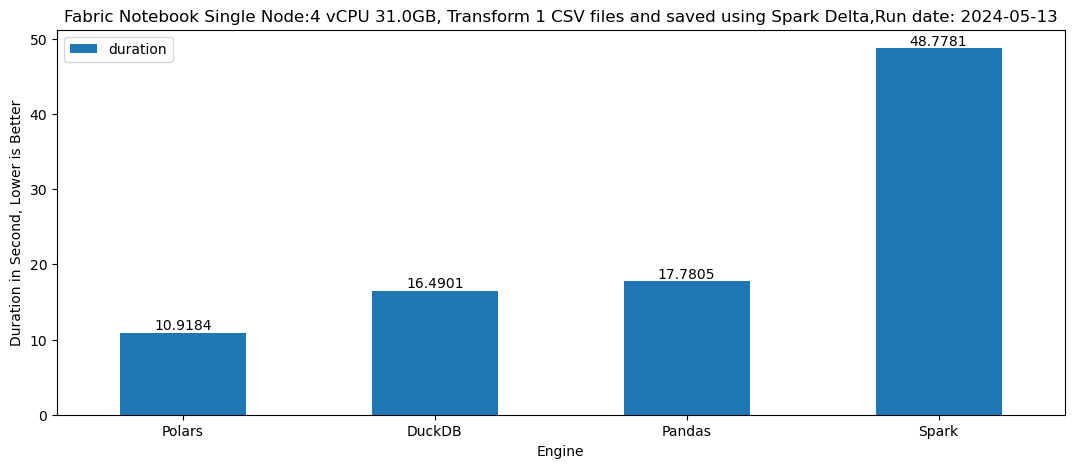

In [18]:
# @title
result = results.groupby(['Engine'])['duration'].sum().reset_index()
result = result.sort_values(by = ['duration'], ascending=[True])
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime ='Fabric Notebook Single Node:'+ vCPU+' '+str(mem)+'GB'+ ', Transform '+ str(total_files)+' CSV files and saved using Spark Delta,Run date: '+ str(time.strftime("%Y-%m-%d"))
ax = result.plot.bar(rot=0,x='Engine',title=runtime,ylabel='Duration in Second, Lower is Better',figsize=(13,5))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')